In [1]:
%config IPCompleter.greedy=True

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import argparse
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from torch.autograd import Variable

import seaborn as sns

import h5py
#import pywt

%pip install pingouin

import pingouin as pg
%pip install matplotlib -U
%pip install Pillow -U

import scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(os.getcwd())

/home/ubuntu/Desktop/matt/Shark Behavior Classification


In [3]:
all_data = './datasets/all_data'

paths = [all_data + '/feeding/csv/Feeding_25Hz_',
         all_data + '/swimming/csv/Swimming_25Hz_',
         all_data + '/resting/csv/Resting_25Hz_',
         all_data + '/ndm/csv/NDM_25Hz_']

In [4]:
'''
Load datasets into pandas
'''
dfs = []

for i in range(7):
    df = pd.concat((pd.read_csv(path + str(i+1) + '.csv',
                                index_col=['Date_Time'],
                                parse_dates=['Date_Time'],
                                infer_datetime_format=True) for path in paths), ignore_index=False, sort=False).iloc[:, 1:9]

    
    df = df.replace(to_replace={"Non directed motion": "NDM"})
    
    dfs.append(df)

In [6]:
static_stats = pd.DataFrame()
dynamic_stats = pd.DataFrame()

static_norms = pd.DataFrame()
dynamic_norms = pd.DataFrame()

for i, df in enumerate(dfs):
    static_stats['Exp ' + str(i+1)] = pd.concat([df[['X_static', 'Y_static', 'Z_static']].max(),
                                                 df[['X_static', 'Y_static', 'Z_static']].min(),
                                                 df[['X_static', 'Y_static', 'Z_static']].mean(),
                                                 df[['X_static', 'Y_static', 'Z_static']].std()], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_stats['Exp ' + str(i+1)] = pd.concat([df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()], keys=['Max', 'Min', 'Mean', 'Std'])

    static_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].max())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].min())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].mean())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])

    
    

In [7]:
static_stats

Exp 1     Exp 2     Exp 3     Exp 4     Exp 5     Exp 6  \
Max  X_static  0.077032  1.024170  1.006630  0.111045  0.120679  0.910788   
     Y_static  0.156563  1.004630  1.002600  0.975836  0.088644 -0.021613   
     Z_static  0.824636  1.014490  0.973284  0.985417  0.926976  0.022193   
Min  X_static -0.950087 -0.253547 -0.211931 -0.914067 -0.906773 -0.781672   
     Y_static -0.988508 -0.658232 -0.551303 -0.314020 -0.978964 -1.000050   
     Z_static -0.821353 -0.976028 -0.987348 -0.979845 -0.835004 -0.901816   
Mean X_static -0.400417  0.446350  0.369005 -0.257957 -0.394168  0.068859   
     Y_static -0.879964  0.718481  0.844067  0.631873 -0.763511 -0.868546   
     Z_static  0.003688  0.306530  0.075490 -0.516440  0.113675 -0.381761   
Std  X_static  0.094312  0.166261  0.238551  0.103277  0.154507  0.173428   
     Y_static  0.078235  0.283534  0.230427  0.183568  0.230552  0.127392   
     Z_static  0.156091  0.347395  0.273057  0.427820  0.295407  0.133636   

                  Exp 7  
Max  X_static  0.270196  
     Y_static  0.974056  
     Z_static  0.992609  
Min  X_static -0.931509  
     Y_static -0.986103  
     Z_static -0.978284  
Mean X_static -0.483220  
     Y_static  0.711312  
     Z_static -0.166788  
Std  X_static  0.129881  
     Y_static  0.212119  
     Z_static  0.345494

In [8]:
dynamic_stats

Exp 1     Exp 2     Exp 3     Exp 4     Exp 5  \
Max  X_dynamic  0.917003  1.412390  0.475683  1.387760  0.552457   
     Y_dynamic  1.316170  0.990695  0.520234  0.755899  0.612059   
     Z_dynamic  0.690294  0.946936  1.035980  0.914963  0.818436   
Min  X_dynamic -0.608845 -0.961168 -0.917072 -1.031950 -0.574540   
     Y_dynamic -0.754519 -1.327120 -1.028350 -1.307330 -0.451837   
     Z_dynamic -1.035620 -1.757400 -1.077940 -0.976593 -0.717468   
Mean X_dynamic  0.000003 -0.000029  0.000006 -0.000004  0.000026   
     Y_dynamic -0.000002  0.000046  0.000019  0.000006 -0.000125   
     Z_dynamic  0.000011 -0.000016 -0.000015 -0.000018 -0.000140   
Std  X_dynamic  0.022189  0.044530  0.016178  0.091395  0.104998   
     Y_dynamic  0.017005  0.034681  0.014545  0.062667  0.073345   
     Z_dynamic  0.025699  0.038335  0.018086  0.093815  0.114178   

                       Exp 6     Exp 7  
Max  X_dynamic  4.894900e-01  1.298910  
     Y_dynamic  6.033030e-01  0.954513  
     Z_dynamic  6.555320e-01  1.247020  
Min  X_dynamic -7.216680e-01 -1.030680  
     Y_dynamic -5.282180e-01 -1.216800  
     Z_dynamic -8.691920e-01 -0.826656  
Mean X_dynamic -3.990769e-07  0.000002  
     Y_dynamic -4.022575e-06  0.000003  
     Z_dynamic -2.418656e-05  0.000005  
Std  X_dynamic  4.146162e-02  0.057362  
     Y_dynamic  3.319764e-02  0.044634  
     Z_dynamic  4.746022e-02  0.062550

In [9]:
static_norms

,,Exp 1,Exp 2,Exp 3,Exp 4,Exp 5,Exp 6,Exp 7
Max,0,0.842894,1.757099,1.722148,1.391270,0.938992,0.911315,1.416709
Min,0,1.598260,1.204237,1.150524,1.376308,1.574115,1.557043,1.672468
Mean,0,0.966791,0.899669,0.924290,0.855871,0.866741,0.951239,0.875947
Std,0,0.198443,0.478244,0.429609,0.476858,0.405330,0.253307,0.425711


In [10]:
dynamic_norms

,,Exp 1,Exp 2,Exp 3,Exp 4,Exp 5,Exp 6,Exp 7
Max,0,1.746340,1.967996,1.253065,1.826039,1.161750,1.016512,2.037970
Min,0,1.418626,2.402820,1.749423,1.930742,1.024213,1.247122,1.796180
Mean,0,0.000012,0.000057,0.000025,0.000019,0.000190,0.000025,0.000006
Std,0,0.037973,0.068229,0.028291,0.145194,0.171583,0.071229,0.095891


## Density Estimation for ODBA Distributions

In [10]:
def kde_plot(data_df, feature='ODBA', log_scale=False):
    label_list = data_df['Label'].unique().tolist()
    for label in label_list:
        class_data = data_df.loc[data_df['Label'] == label][feature]

        # Draw the density plot for original data
        ax = sns.kdeplot(data=class_data, legend=True, log_scale=log_scale)

    ax.legend(label_list)

    plt.show()
    plt.clf()

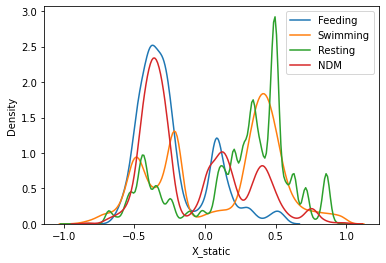

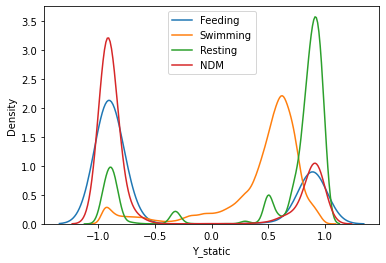

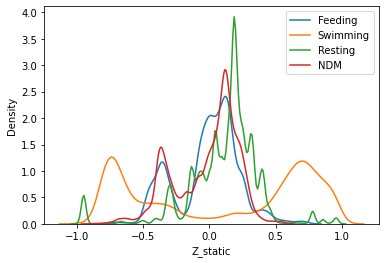

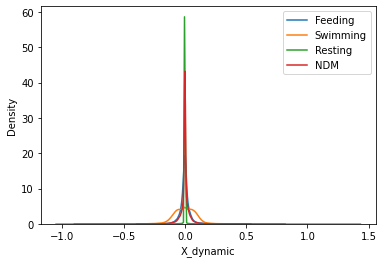

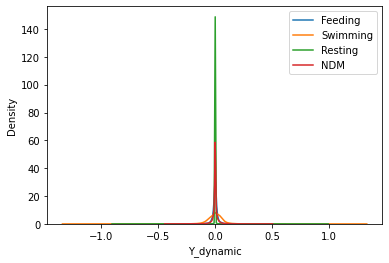

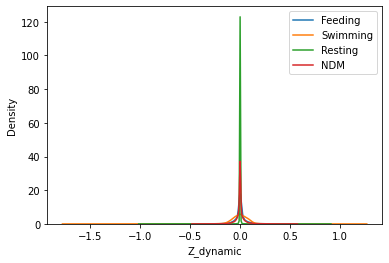

<Figure size 432x288 with 0 Axes>

In [16]:
kde_plot(pd.concat(dfs), feature='X_static')
kde_plot(pd.concat(dfs), feature='Y_static')
kde_plot(pd.concat(dfs), feature='Z_static')
kde_plot(pd.concat(dfs), feature='X_dynamic')
kde_plot(pd.concat(dfs), feature='Y_dynamic')
kde_plot(pd.concat(dfs), feature='Z_dynamic')

In [15]:
for i, df in enumerate(dfs):
    print("Normality test for Exp " + str(i+1))
    f_data = df.loc[df['Label'] == 'NDM']['X_dynamic']
#     f_data = df[['ODBA']]
#     log_f = np.log10(f_data)
    
#     plt.hist(f_data, bins='auto')
#     plt.show()

#     plt.hist(log_f, bins='auto')
#     plt.show()

#     sm.qqplot(f_data, line ='r')
#     plt.show()
    
#     sm.qqplot(log_f, line ='r')
#     plt.show()
    
    print(scipy.stats.normaltest(f_data))
#     print(scipy.stats.normaltest(log_f))
    
#     print(pg.normality(f_data, alpha=0.05))
#     print(pg.normality(log_f, alpha=0.05))

#     rand_idx = np.random.randint(0,len(df)-5000)
#     print(pg.normality(log_f[rand_idx:rand_idx+5000]), alpha=0.05)
    
#     print(pg.multivariate_normality(df[['X_dynamic', 
#                                         'Y_dynamic', 
#                                         'Z_dynamic']][rand_idx:rand_idx+5000], alpha=0.05))

Normality test for Exp 1
NormaltestResult(statistic=10456.260645426632, pvalue=0.0)
Normality test for Exp 2
NormaltestResult(statistic=2651.0667847342456, pvalue=0.0)
Normality test for Exp 3
NormaltestResult(statistic=3773.341732922815, pvalue=0.0)
Normality test for Exp 4
NormaltestResult(statistic=35.82541614306982, pvalue=1.6619185240828925e-08)
Normality test for Exp 5
NormaltestResult(statistic=493.4593772574824, pvalue=7.025184053167471e-108)
Normality test for Exp 6
NormaltestResult(statistic=4953.784259320618, pvalue=0.0)
Normality test for Exp 7
NormaltestResult(statistic=591.6500556019514, pvalue=3.3482880831153435e-129)


## Normality Tests

In [ ]:
mean, cov, n = [4, 5], [(0.6, 0.4), (0.4, 0.6)], 5000
x, y = np.random.multivariate_normal(mean, cov, n).T

In [ ]:
print(pg.normality(x))
print(pg.normality(y))
print(pg.multivariate_normality(np.column_stack((x, y))))

In [ ]:
# plt.hist(x, bins='auto')
# plt.show()
# plt.hist(y, bins='auto')
# plt.show()

plt.hist2d(x, y, bins=(69, 69), cmap='gray')
plt.show()

In [ ]:
%pip install statsmodels
import statsmodels.api as sm

In [ ]:
sm.qqplot(y, line ='45')
plt.show()

## Data split

In [17]:
# Train: 1, 2, 3, 4, 7
# Val: 6
# Test: 5
train_df = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3], dfs[6]])
val_df = dfs[5]
test_df = dfs[4]

In [18]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1646579, 8)
(77650, 8)
(16775, 8)


In [19]:
train_data = train_df[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic', 'Label']]
val_data = val_df[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic', 'Label']]
test_data = test_df[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic', 'Label']]

In [20]:
print([df['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic'].isna().values.any() for df in dfs])
print(train_data['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic'].isna().values.any())
print(val_data['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic'].isna().values.any())
print(test_data['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic'].isna().values.any())

KeyError: ('X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic')

In [18]:
mean = np.mean(train_odba['ODBA'])
std  = np.std(train_odba['ODBA'])

train_odba['ODBA'] = train_odba['ODBA'].map(lambda x: (x-mean)/std)
val_odba['ODBA']   = val_odba['ODBA'].map(lambda x: (x-mean)/std)
test_odba['ODBA']  = test_odba['ODBA'].map(lambda x: (x-mean)/std)

In [19]:
print(np.mean(train_odba['ODBA']))
print(np.std(train_odba['ODBA']))

print(np.mean(val_odba['ODBA']))
print(np.std(val_odba['ODBA']))

print(np.mean(test_odba['ODBA']))
print(np.std(test_odba['ODBA']))

-6.691770216903668e-16
1.0
0.3395328231064771
0.9564730296692303
0.9070996505569311
1.1531582814935093


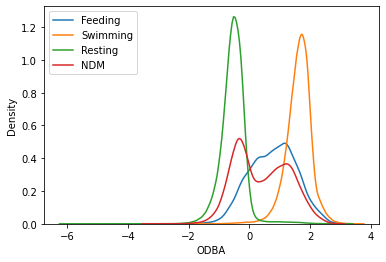

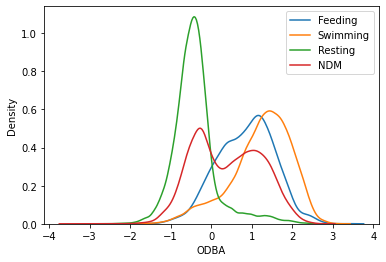

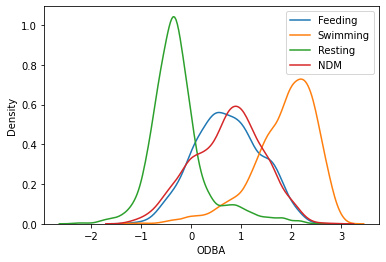

<Figure size 432x288 with 0 Axes>

In [25]:
kde_plot(train_odba)
kde_plot(val_odba)
kde_plot(test_odba)

## Group contiguous time intervals

In [237]:
def group_times(df):
    time_diff = df.index.to_series().diff()
    breaks = time_diff > pd.Timedelta('1s')
    groups = breaks.cumsum()
    
    df['Group'] = groups
    
    return df

In [238]:
train_odba = group_times(train_odba)
val_odba = group_times(val_odba)
test_odba = group_times(test_odba)

In [266]:
def sample_sequences(df, num_samples=None, seq_len=50, dims=1, train=True):
    X = []
    Y = []
    
    label_list = ['Feeding', 'Swimming', 'Resting', 'NDM']
    
    for idx, label in enumerate(label_list):
        print(str(idx) + ": " + label)
        
        if train:
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                data = []
                while(len(data) == 0):
                    chunk_idx = np.random.randint((df['Group'].max()+1))
                    
                    data = df.loc[(df['Label'] == label) & (df['Group'] == chunk_idx)]['ODBA'].to_numpy()
                
                rand = np.random.randint(len(data)-seq_len)
                
                if dims == 1:
                    X_class[i] = np.expand_dims(data[rand:rand+seq_len], axis=1)
                else:
                    X_class[i] = data[rand:rand+seq_len]
                
        else:
            data = df.loc[df['Label'] == label]['ODBA'].to_numpy()
            
            num_samples = len(data)//50
            print(num_samples)
            
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                if dims == 1:
                    X_class[i] = np.expand_dims(data[seq_len*i:seq_len*(i+1)], axis=1)
                else:
                    X_class[i] = data[seq_len*i:seq_len*(i+1)]
                    
        X.append(X_class)
        Y.append(Y_class)
        
    return X, Y

In [248]:
X_train, Y_train = sample_sequences(train_odba, num_samples=10000)

0: Feeding
1: Swimming
2: Resting
3: NDM


In [252]:
X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

In [256]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state=33)

In [257]:
X_val, Y_val = sample_sequences(val_odba, num_samples=2000)

0: Feeding
1: Swimming
2: Resting
3: NDM


In [258]:
X_val = np.concatenate(X_val)
Y_val = np.concatenate(Y_val)

In [259]:
X_val, Y_val = shuffle(X_val, Y_val, random_state=33)

In [260]:
print(X_train.mean())
print(X_train.std())

print(X_val.mean())
print(X_val.std())

0.71874774
1.0093136
0.6143054
0.9373075


In [261]:
from collections import Counter

print(Counter(np.squeeze(Y_train).tolist()))
print(Counter(np.squeeze(Y_val).tolist()))

Counter({0: 10000, 3: 10000, 2: 10000, 1: 10000})
Counter({0: 2000, 3: 2000, 1: 2000, 2: 2000})


In [262]:
test_odba.count()

ODBA     16775
Label    16775
Group    16775
dtype: int64

In [267]:
X_test, Y_test = sample_sequences(test_odba, train=False)

0: Feeding
17
1: Swimming
159
2: Resting
123
3: NDM
35


In [268]:
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

In [269]:
print(X_test.shape)
print(Y_test.shape)

(334, 50, 1)
(334, 1)


In [270]:
test_odba['Label'].value_counts()//50

Swimming    159
Resting     123
NDM          35
Feeding      17
Name: Label, dtype: int64

In [271]:
sum(test_odba['Label'].value_counts()//50)

334

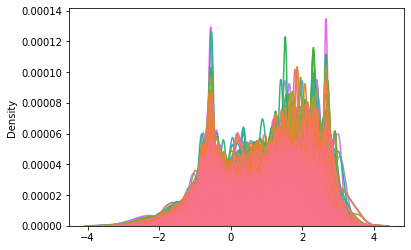

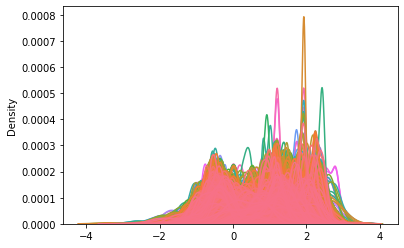

<Figure size 432x288 with 0 Axes>

In [272]:
## This estimates the distribution of each sequence (40,000/2,000 distributions, each of 50 samples)
ax = sns.kdeplot(data=np.squeeze(X_train).T, legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val).T, legend=False)

plt.show()
plt.clf()

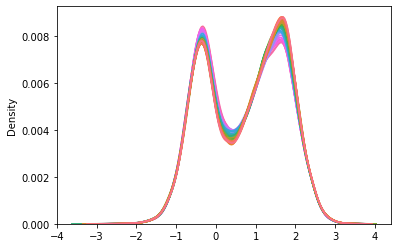

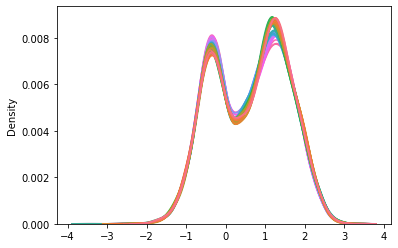

<Figure size 432x288 with 0 Axes>

In [273]:
## This estimates the distribution of each sequence element (50 distributions, each of 40,000/2,000 samples)
ax = sns.kdeplot(data=np.squeeze(X_train), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val), legend=False)

plt.show()
plt.clf()

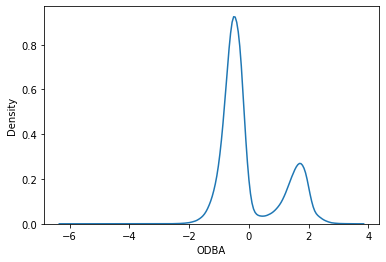

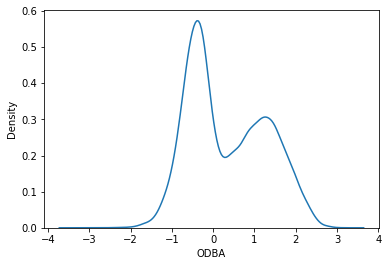

<Figure size 432x288 with 0 Axes>

In [274]:
## This estimates the distribution over the train and val sets, respectively
ax = sns.kdeplot(data=train_odba['ODBA'], legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=val_odba['ODBA'], legend=False)

plt.show()
plt.clf()

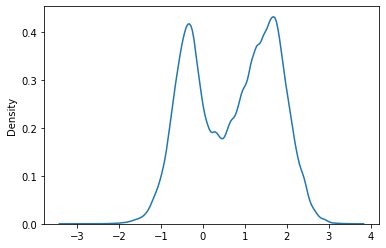

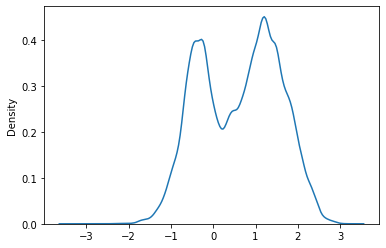

<Figure size 432x288 with 0 Axes>

In [275]:
ax = sns.kdeplot(data=X_train.flatten(), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=X_val.flatten(), legend=False)

plt.show()
plt.clf()

In [276]:
def write(data, gts, outfile):
    '''
        This function writes the pre-processed image data to a HDF5 file
        Args:
          data: numpy.array, image data as numpy array
          outfile: string, path to write file to
    '''
    print("---------------------------------------")
    print("Saving data")
    print("---------------------------------------\n")
    with h5py.File(outfile, "w") as f:
        f.create_dataset("features", data=data, dtype=data.dtype)
        f.create_dataset("gts", data=gts, dtype=gts.dtype)

def load(infile, dataset):
    '''
        This function loads the image data from a HDF5 file 
        Args:
          outfile: string, path to read file from
          
        Returns:
          f["image"][()]: numpy.array, image data as numpy array
    '''
    print("---------------------------------------")
    print("Loading data")
    print("---------------------------------------\n")
    with h5py.File(infile, "r") as f:
        return f[dataset][()]

In [277]:
write(X_train, Y_train, './datasets/data/1d/train/data.hdf5')
write(X_val, Y_val, './datasets/data/1d/val/data.hdf5')
write(X_test, Y_test, './datasets/data/1d/test/orig/data.hdf5')

---------------------------------------
Saving data
---------------------------------------

---------------------------------------
Saving data
---------------------------------------

---------------------------------------
Saving data
---------------------------------------



In [278]:
X_train

array([[[-0.51646596],
        [-0.09984019],
        [ 0.09662148],
        ...,
        [ 0.2631911 ],
        [ 0.3947596 ],
        [ 0.09952848]],

       [[ 1.0884948 ],
        [ 0.9506511 ],
        [ 0.94109464],
        ...,
        [ 0.55273896],
        [ 0.3046928 ],
        [ 0.18684024]],

       [[-0.5981214 ],
        [-0.07187977],
        [-0.51040566],
        ...,
        [-0.5819391 ],
        [-0.75129926],
        [-0.10454385]],

       ...,

       [[ 1.9195501 ],
        [ 1.9881539 ],
        [ 2.0321922 ],
        ...,
        [ 1.0964018 ],
        [ 1.0490651 ],
        [ 0.84927195]],

       [[ 0.06728057],
        [ 0.23828593],
        [ 0.7300881 ],
        ...,
        [ 0.17663176],
        [ 0.1399254 ],
        [ 0.11602405]],

       [[-0.6317163 ],
        [-0.26743725],
        [-0.65913516],
        ...,
        [-0.59894514],
        [-0.7175836 ],
        [-0.22579661]]], dtype=float32)

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------



array([[0],
       [3],
       [2],
       ...,
       [3],
       [0],
       [2]])